## Магистрант: Шилллер Эдуард - 2 ML&DS 

### 1. Цветовая модель RGB.

RGB (Red, Green, Blue) - аддитивная цветовая модель, в которой любой цвет представляется как сумма трёх компонент: красной (R), зелёной (G) и синей (B).

“Аддитивная” значит: чем больше света добавляем, тем светлее итоговый цвет.

На практике чаще всего используют 8 бит на канал: каждое значение 0..255, а пиксель - это (R,G,B).
Примеры:

(0,0,0) - чёрный

(255,255,255) - белый

### 2. Библиотека OpenCV: архитектура, возможности, ключевые концепции. 
OpenCV (Open Source Computer Vision Library) - библиотека для обработки изображений/видео и задач компьютерного зрения.

Изображение как матрица (numpy array): H×W×C.
Цветовые пространства: OpenCV по умолчанию хранит цвет как BGR, не RGB.

Из возможностей:
* Предобработка: resize, scale, crop, blur и т.п.
* Детекция/сегментация: контуры, линии, углы, пороги
* Feature matching: сопоставление изображений
* Геометрия: гомография, перспективные преобразования
* Панорамы (stitching)

Например, в контексте данного экзаменационного задания, имеет место быть следующий pipeline: загрузка -> предобработка -> анализ/сшивка -> постобработка.

### 3.Написать код в Jupyter-notebook (Python, colab) для получения изображения панорамы из разрозненных фотографий, применяя методы обработки цифрового изображения:
a) скачать из репозитария изображение, содержащее набор фотографий для создания панорамы.

b) сделать необходимые преобразования кодом для создания панорамы (crop, trim, transformation, etc).

c) сделать улучшение качества изображения (upscale 4k) методами bicubic, ESRGAN

d) опционально:  убрать шумы, дополнительные модели по улучшению изображения панорамы.


In [46]:
!pip -q install opencv-python numpy matplotlib requests scikit-learn


In [47]:
!pip list

Package                 Version
----------------------- ------------
aistudio-sdk            0.3.8
annotated-types         0.7.0
anyio                   4.12.0
asttokens               3.0.0
bce-python-sdk          0.9.56
certifi                 2025.11.12
chardet                 5.2.0
charset-normalizer      3.4.4
click                   8.3.1
colorama                0.4.6
colorlog                6.10.1
comm                    0.2.3
contourpy               1.3.3
cycler                  0.12.1
debugpy                 1.8.17
decorator               5.2.1
easyocr                 1.7.2
executing               2.2.1
filelock                3.19.1
fonttools               4.60.1
fsspec                  2025.9.0
future                  1.0.0
h11                     0.16.0
hf-xet                  1.2.0
httpcore                1.0.9
httpx                   0.28.1
huggingface_hub         1.2.3
idna                    3.11
ImageIO                 2.37.2
imagesize               1.4.1
ipykernel     

In [ ]:
# Pipline данного блока кода: загрузка -> предобработка -> анализ/сшивка

import cv2
import numpy as np
from itertools import permutations
from sklearn.metrics import mean_squared_error
 
# 1. Загрузка изображения и поиск контуров (маска)
img = cv2.imread("E_4.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
 
# 2. Взять только "крупные" контуры (фрагменты)
rects = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if w * h > 6000:        # фильтр по площади
        rects.append((x, y, w, h))
 
print("Сырых фрагментов (контуров):", len(rects))
 
# 3. Группировка контуров по X, чтобы склеить верх+низ в один столбец
#    (кусочки с почти одинаковым центром по X считаем одним фрагментом)
centers_x = [x + w / 2 for (x, y, w, h) in rects]
mean_w = np.mean([w for (x, y, w, h) in rects])
tol = mean_w * 0.6          # допустимое отклонение центров по X
 
groups = []
for (x, y, w, h) in rects:
    cx = x + w / 2
    assigned = False
    for g in groups:
        if abs(cx - g["cx"]) < tol:
            g["rects"].append((x, y, w, h))
            # обновляем центр группы
            g["cx"] = np.mean([rx + rw / 2 for (rx, ry, rw, rh) in g["rects"]])
            assigned = True
            break
    if not assigned:
        groups.append({"cx": cx, "rects": [(x, y, w, h)]})
 
print("После объединения по X (столбцы):", len(groups))
 
# 4. Для каждой группы берём объединяющий bounding box и режем единый столбец
parts = []
for g in groups:
    xs  = [x for (x, y, w, h) in g["rects"]]
    ys  = [y for (x, y, w, h) in g["rects"]]
    x2s = [x + w for (x, y, w, h) in g["rects"]]
    y2s = [y + h for (x, y, w, h) in g["rects"]]
 
    x_min, x_max = min(xs), max(x2s)
    y_min, y_max = min(ys), max(y2s)
 
    crop = img[y_min:y_max, x_min:x_max]
    parts.append((g["cx"], crop))
 
# 5. Сортировка части по X (чтобы permutation не зависел от порядка findContours)
parts.sort(key=lambda x: x[0])
parts_only = [p for (_, p) in parts]
 
print("Итоговых фрагментов:", len(parts_only))
 
# --- функция оценки стыка двух фрагментов ---
def edge_score(a, b):
    ra = a[:, -15:]   # правая кромка A
    lb = b[:, :15]    # левая кромка B
    h = min(ra.shape[0], lb.shape[0])
    ra = cv2.resize(ra, (15, h))
    lb = cv2.resize(lb, (15, h))
    return mean_squared_error(ra.flatten(), lb.flatten())
 
# 6. Перебор всех перестановок и поиск порядка с минимальной ошибкой
n = len(parts_only)
best_order = None
best_score = 1e18
 
for perm in permutations(range(n)):
    s = 0
    for i in range(n - 1):
        s += edge_score(parts_only[perm[i]], parts_only[perm[i + 1]])
    if s < best_score:
        best_score = s
        best_order = perm
 
print("Лучший порядок:", best_order)
print("Суммарная ошибка:", best_score)
 
# 7. Склеивание фрагментов в одну панораму
ordered = [parts_only[i] for i in best_order]
h = max(p.shape[0] for p in ordered)
w = sum(p.shape[1] for p in ordered)
canvas = np.zeros((h, w, 3), dtype=np.uint8)
 
x = 0
for p in ordered:
    ph, pw = p.shape[:2]
    canvas[:ph, x:x+pw] = p
    x += pw
 
cv2.imwrite("sum.jpg", canvas)
print("Готово: sum.jpg")

Сырых фрагментов (контуров): 8
После объединения по X (столбцы): 7
Итоговых фрагментов: 7
Лучший порядок: (2, 6, 1, 0, 3, 5, 4)
Суммарная ошибка: 16033.644762889136
Готово: sum.jpg


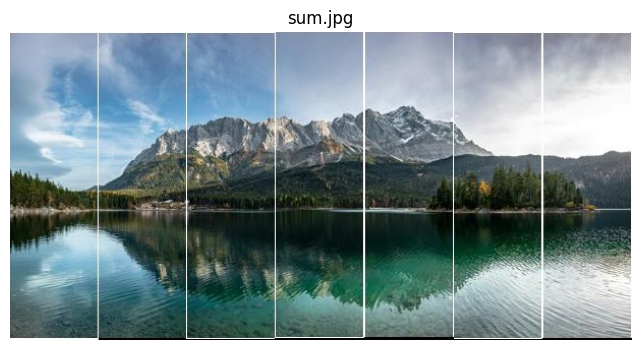

In [ ]:
# Вывод изображения

import cv2
import matplotlib.pyplot as plt

img = cv2.imread("sum.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,4))
plt.imshow(img_rgb)
plt.axis("off")
plt.title("sum.jpg")
plt.show()


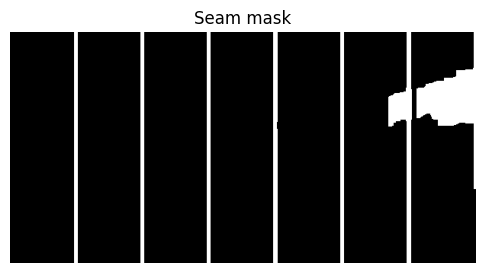

Saved: sum_clean.png


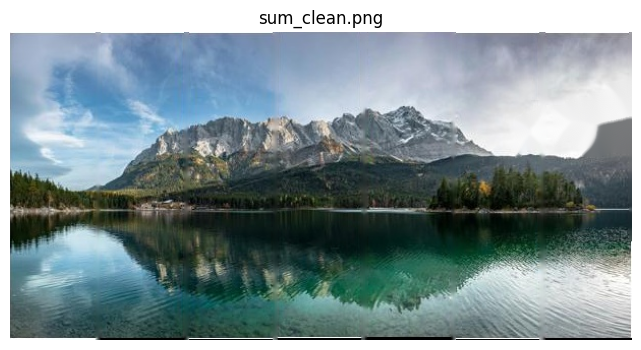

In [ ]:
# Постобработка - удаление швов

import cv2
import numpy as np
import matplotlib.pyplot as plt

IN_PATH = "sum.jpg"         
OUT_PATH = "sum_clean.png"    
WHITE_V_THR = 245   # яркость (V)
WHITE_S_THR = 40    # насыщенность (S) 
INPAINT_RADIUS = 3 

# 1. Загрузка
bgr = cv2.imread(IN_PATH)
assert bgr is not None, f"Не найден файл: {IN_PATH}"

# 2. Создание маски швов (белых вертикальных линий)
hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
H, S, V = cv2.split(hsv)
white = ((V >= WHITE_V_THR) & (S <= WHITE_S_THR)).astype(np.uint8) * 255 # "Почти белое": высокая яркость + низкая насыщенность

# Вытаскиваем именно вертикальные линии (швы)
kernel_v = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 31))
seams = cv2.morphologyEx(white, cv2.MORPH_OPEN, kernel_v, iterations=1)

# Расширение шввов на пару пикселей, чтобы inpaint захватил края
kernel_d = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
seams = cv2.dilate(seams, kernel_d, iterations=1)
seams = cv2.morphologyEx(seams, cv2.MORPH_CLOSE, kernel_d, iterations=1) # Немного подчистил маску

# Показать маску
plt.figure(figsize=(10,3))
plt.imshow(seams, cmap="gray")
plt.axis("off")
plt.title("Seam mask")
plt.show()

# 3. Удаление швов
clean_bgr = cv2.inpaint(bgr, seams, inpaintRadius=INPAINT_RADIUS, flags=cv2.INPAINT_TELEA)

cv2.imwrite(OUT_PATH, clean_bgr)
print("Saved:", OUT_PATH)
clean_rgb = cv2.cvtColor(clean_bgr, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,4))
plt.imshow(clean_rgb)
plt.axis("off")
plt.title("sum_clean.png")
plt.show()


In [ ]:
# Кроп 5 пикселей, чтобы убрать артефакты по краям

import cv2
img = cv2.imread("sum_clean.png")
cropped = img[5:-5, 5:-5]
cv2.imwrite("sum_clean_trim5.png", cropped)
print("Saved: sum_clean_trim5.png")


Saved: sum_clean_trim5.png


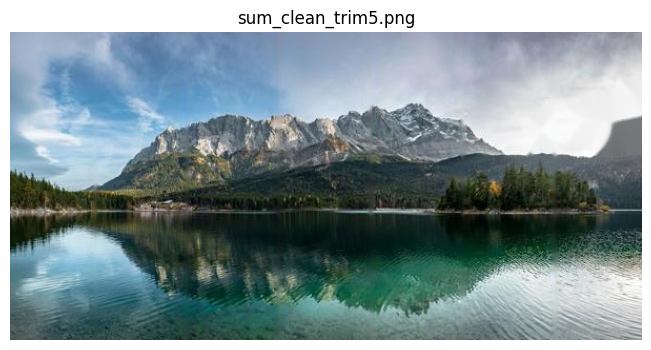

In [ ]:
# Вывод результата после кропа

import cv2
import matplotlib.pyplot as plt

img = cv2.imread("sum_clean_trim5.png")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,4))
plt.imshow(img_rgb)
plt.axis("off")
plt.title("sum_clean_trim5.png")
plt.show()


Saved: sum_clean_4k_quality.png


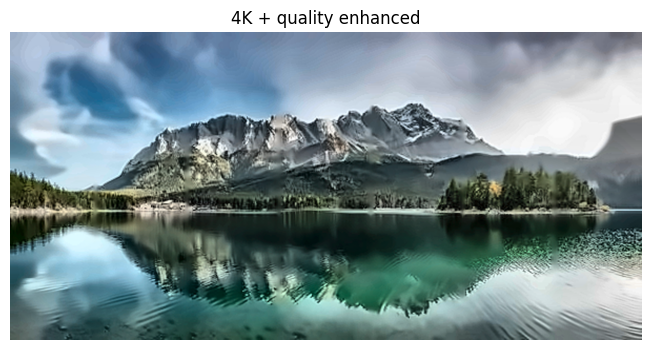

In [ ]:
# Постобработка - апскейл до 4K + улучшение качества

import cv2
import numpy as np
import matplotlib.pyplot as plt

IN_PATH = "sum_clean_trim5.png"
OUT_PATH = "sum_clean_4k_quality.png"
TARGET_W = 3840  # 4K по ширине

# Загрузка
img = cv2.imread(IN_PATH)

# 1. Мягкое шумоподавление
img = cv2.fastNlMeansDenoisingColored(
    img, None,
    h=6, hColor=6,
    templateWindowSize=7, searchWindowSize=21
)

# 2. Повышение локального контраста (CLAHE по яркости)
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
l = clahe.apply(l)
lab = cv2.merge((l, a, b))
img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

# 3. Лёгкая резкость (unsharp mask)
blur = cv2.GaussianBlur(img, (0,0), 1.0)
img = cv2.addWeighted(img, 1.25, blur, -0.25, 0)

# 4. апскейл до 4K 
h, w = img.shape[:2]
scale = TARGET_W / w
target_h = int(h * scale)

img_4k = cv2.resize(img, (TARGET_W, target_h), interpolation=cv2.INTER_CUBIC)

# Сохранить
cv2.imwrite(OUT_PATH, img_4k)
print("Saved:", OUT_PATH)

# Показать
plt.figure(figsize=(12,4))
plt.imshow(cv2.cvtColor(img_4k, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("4K + quality enhanced")
plt.show()


Saved: sum_clean_4k_pretty.png


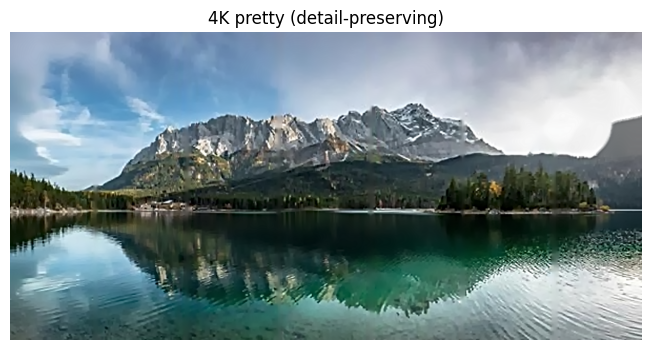

In [ ]:
# Постобработка - апскейл до 4K с сохранением деталей (вариант 2) 

import cv2
import numpy as np
import matplotlib.pyplot as plt

IN_PATH  = "sum_clean_trim5.png"
OUT_PATH = "sum_clean_4k_pretty.png"
TARGET_W = 3840

img = cv2.imread(IN_PATH)

# 1. Апскейл до 4K (без предварительного "мыла")
h, w = img.shape[:2]
scale = TARGET_W / w
img4k = cv2.resize(img, (TARGET_W, int(h * scale)), interpolation=cv2.INTER_CUBIC)

# 2. Сохранение деталей: edge-preserving + detail enhance
img4k = cv2.edgePreservingFilter(img4k, flags=1, sigma_s=35, sigma_r=0.15)
img4k = cv2.detailEnhance(img4k, sigma_s=10, sigma_r=0.12)

# 3. Лёгкая резкость (unsharp) - возвращает микродетали
blur = cv2.GaussianBlur(img4k, (0,0), 1.1)
img4k = cv2.addWeighted(img4k, 1.22, blur, -0.22, 0)

cv2.imwrite(OUT_PATH, img4k)
print("Saved:", OUT_PATH)

plt.figure(figsize=(12,4))
plt.imshow(cv2.cvtColor(img4k, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("4K pretty (detail-preserving)")
plt.show()
